In [108]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np

In [5]:
# Check that the CSV was read properly
movie_list = pd.read_csv("movies.csv")
movie_list.head()

,Title
0,The Shawshank Redemption
1,The Godfather
2,The Dark Knight
3,The Godfather Part II
4,12 Angry Men


In [6]:
# Add id column to the DataFrame
movie_list['id'] = ''
movie_list

,Title,id
0,The Shawshank Redemption,
1,The Godfather,
2,The Dark Knight,
3,The Godfather Part II,
4,12 Angry Men,
...,...,...
245,Jai Bhim,
246,Aladdin,
247,Gandhi,
248,The Help,


In [7]:
# TMDB API call
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/yIonSXf1jdNihhK8PssxO6KCIfz.jpg",
            "genre_ids": [
                878,
                18
            ],
            "id": 185,
            "original_language": "en",
            "original_title": "A Clockwork Orange",
            "overview": "In a near-future Britain, young Alexander DeLarge and his pals get their kicks beating and raping anyone they please. When not destroying the lives of others, Alex swoons to the music of Beethoven. The state, eager to crack down on juvenile crime, gives an incarcerated Alex the option to undergo an invasive procedure that'll rob him of all personal agency. In a time when conscience is a commodity, can Alex change his tune?",
            "popularity": 37.504,
            "poster_path": "/4sHeTAp65WrSSuc05nRBKddhBxO.jpg",
            "release_date": "1971-12-19",
            "title": "A Clockwork Orange",
            "video": false,
   

In [8]:
#response['results'][0]['id']

In [9]:
#OMDB API call
url = "http://www.omdbapi.com/?t="
#api_key = "&apikey=" + api_key
api_key_url = "&apikey=" + omdb_api_key
#print(api_key_url)
response = requests.get(url + "Jack Reacher" + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "Tom Cruise, Rosamund Pike, Richard Jenkins",
    "Awards": "1 win & 6 nominations",
    "BoxOffice": "$80,070,736",
    "Country": "United States",
    "DVD": "31 Dec 2014",
    "Director": "Christopher McQuarrie",
    "Genre": "Action, Mystery, Thriller",
    "Language": "English",
    "Metascore": "50",
    "Plot": "A homicide investigator digs deeper into a case involving a trained military sniper responsible for a mass shooting.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BMTM1NjUxMDI3OV5BMl5BanBnXkFtZTcwNjg1ODM3OA@@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "PG-13",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "7.0/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "63%"
        },
        {
            "Source": "Metacritic",
            "Value": "50/100"
        }
    ],
    "Released": "21 Dec 2012",
    "Response": "True",
    "Runtime": "130 min",
 

In [10]:
# Loop through the CSV's Title column to call said movie from the API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

In [11]:
# View the movies not found in the database
unfound_movies

['Gisaengchung', 'Oldeuboi', 'Capharnaüm']

In [12]:
#Print the DataFrame along with it's shape
print(movie_list.shape)
movie_list

(250, 2)


,Title,id
0,The Shawshank Redemption,278
1,The Godfather,238
2,The Dark Knight,155
3,The Godfather Part II,240
4,12 Angry Men,389
...,...,...
245,Jai Bhim,855400
246,Aladdin,420817
247,Gandhi,783
248,The Help,50014


In [13]:
# Export the City_Data into a csv
#movie_list.to_csv("movie_list.csv")

In [14]:
# movie_list_df = movie_list.loc[movie_list['id']=='NaN']
# movie_list_df

In [15]:
#Drop NaN rows
movie_list.dropna(how='any',inplace=True)

In [16]:
#Check size of Data Frame
movie_list.shape

(247, 2)

In [17]:
#Add columns name to the DataFrame
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,The Shawshank Redemption,278,,,,,,,,,
1,The Godfather,238,,,,,,,,,
2,The Dark Knight,155,,,,,,,,,
3,The Godfather Part II,240,,,,,,,,,
4,12 Angry Men,389,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
245,Jai Bhim,855400,,,,,,,,,
246,Aladdin,420817,,,,,,,,,
247,Gandhi,783,,,,,,,,,
248,The Help,50014,,,,,,,,,


In [18]:
# # Defining the path for each column value

#imdb_id = url_byid_response['imdb_id']
#release_date = url_byid_response['release_date']
#url_byid_response['revenue']
#url_byid_response['runtime']

# #extracting genre names from list
# for i in range(0,len(url_byid_response['genres'])):
#     print(url_byid_response['genres'][i]['name'])

# #extracting genre names from list
# for i in range(0,len(url_byid_response['production_countries'])):
#     print(url_byid_response['production_countries'][i]['name'])

#url_byid_response['popularity']
#url_byid_response['budget']

#url_byid_response['vote_average']


In [19]:
# #API call, search movie by ID
# for i in range(0,len(movie_list['Title']))
#     movie_id=movie_list['id'][i]
#     url_ById = "https://api.themoviedb.org/3/movie/"
#     build_url_ById=f"{url_ById}{movie_id}?api_key={api_key}"
#     url_byid_response=requests.get(build_url_ById).json()
#     #print(json.dumps(url_byid_response, indent=4, sort_keys=True))

In [20]:
# Loop through each movie's title for the API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [21]:
movie_list.head()

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,The Shawshank Redemption,278,tt0111161,25000000,"Drama, Crime",28341469,142,94.45,1994-09-23,United States of America,8.704
1,The Godfather,238,tt0068646,6000000,"Drama, Crime",245066411,175,100.146,1972-03-14,United States of America,8.709
2,The Dark Knight,155,tt0468569,185000000,"Drama, Action, Crime, Thriller",1004558444,152,91.063,2008-07-16,"United Kingdom, United States of America",8.512
3,The Godfather Part II,240,tt0071562,13000000,"Drama, Crime",102600000,202,60.45,1974-12-20,United States of America,8.6
4,12 Angry Men,389,tt0050083,350000,Drama,1000000,97,39.315,1957-04-10,United States of America,8.5


In [22]:
movie_list.shape

(247, 11)

In [23]:
# Create a new "Year" column from the "release date" by making a new df converting to datetime
movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year
# movie_list.drop("release_date", axis=1, inplace=True)
movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
           "popularity", "tmdb_rating"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5
...,...,...,...,...,...,...,...,...,...,...,...
245,Jai Bhim,2021,855400,tt15097216,"Crime, Drama, Mystery",164,0,0,India,7.445,7.476
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2


In [24]:
# # Export the movie_df into a csv
# movie_list.to_csv("movie_df.csv")

In [25]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2      False
3      False
4      False
       ...  
245     True
246    False
247    False
248    False
249    False
Name: budget, Length: 247, dtype: bool

In [26]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# len(no_budget_df["budget"])
# no_budget_df

In [27]:
# View how many movies with no budget had no revenue either
# no_revenue = no_budget_df["revenue"]==0
# no_revenue.value_counts()

In [28]:
# Removing rows with zero budget movies
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5
...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2


In [29]:
# View if a movie had 0 budget or not (true/false)
movie_list["budget"].min()


133000

In [30]:
# View if a movie had 0 revenue or not (true/false)
no_revenue_1 = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue_1

0      False
1      False
2      False
3      False
4      False
       ...  
244    False
246    False
247    False
248    False
249    False
Name: revenue, Length: 223, dtype: bool

In [31]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue_1]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5
...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2


In [32]:
# View if a movie had 0 revenue or not (true/false)
movie_list["revenue"].min()


96568

In [33]:
# Looking at a sampling of dataframe
print(movie_list.shape)
movie_list.sample(5)

(221, 11)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
21,The Silence of the Lambs,1991,274,tt0102926,"Crime, Drama, Thriller",119,19000000,272742922,United States of America,12.48,8.343
177,On the Waterfront,1954,654,tt0047296,"Crime, Drama",108,910000,9600000,United States of America,14.477,7.94
16,GoodFellas,1990,769,tt0099685,"Drama, Crime",145,25000000,46835000,United States of America,46.986,8.466
199,Wild Tales,2014,265195,tt3011894,"Drama, Thriller, Comedy",122,4000000,27007072,"Argentina, Spain",23.613,7.865
111,Up,2009,14160,tt1049413,"Animation, Comedy, Family, Adventure",96,175000000,735099082,United States of America,95.5,7.95


In [34]:
# #OMDB API call
# url = "http://www.omdbapi.com/?t="
# #api_key = "&apikey=" + api_key
# api_key_url = "&apikey=" + omdb_api_key
# #print(api_key_url)
# response = requests.get(url + "Jack Reacher" + api_key_url).json()
# print(json.dumps(response, indent=4, sort_keys=True))

In [35]:
for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_rating"] = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_votes"] = url_byid_response['imdbVotes']
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_31122/2544307824.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[index, "imdb_rating"] = url_byid_response['imdbRating']
/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_31122/2544307824.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[index, "imdb_votes"] = url_byid_response['imdbVotes']


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704,9.3,"2,802,199"
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709,9.2,"1,954,449"
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512,9.0,"2,786,837"
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6,9.0,"1,327,261"
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,9.0,"832,893"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246,8.1,"163,835"
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113,6.9,"282,377"
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544,8.0,"237,597"
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2,8.1,"480,538"


# Movie Data Analysis

In [47]:
# Runtime over the years

# data = movie_list['Year']
# df = movie_list.DataFrame(data)

# Define custom bin edges
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]

# Cut the data into custom intervals
movie_list['Decades'] = pd.cut(movie_list['Year'], bins=bin_edges)
movie_list

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_31122/641263221.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['Decades'] = pd.cut(movie_list['Year'], bins=bin_edges)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,Decades
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704,9.3,"2,802,199","(1990, 2000]"
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709,9.2,"1,954,449","(1970, 1980]"
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512,9.0,"2,786,837","(2000, 2010]"
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6,9.0,"1,327,261","(1970, 1980]"
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,9.0,"832,893","(1950, 1960]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246,8.1,"163,835","(2010, 2020]"
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113,6.9,"282,377","(2010, 2020]"
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544,8.0,"237,597","(1980, 1990]"
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2,8.1,"480,538","(2010, 2020]"


<Axes: title={'center': 'Number of Movies per decade'}, xlabel='Decades', ylabel='Number of Movies'>

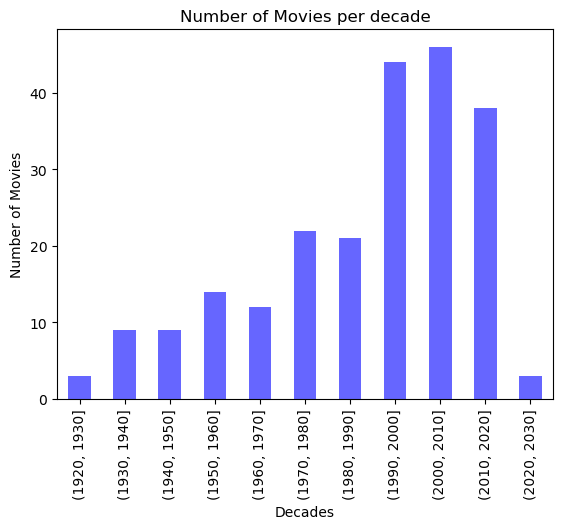

In [37]:
# Create a bar chart based upon the above data
# x_axis = np.arange(movie_list['Decades'])
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar',
            alpha=0.6,
            color='blue', 
            title="Number of Movies per decade",
            xlabel="Decades",
            ylabel="Number of Movies")
# plt.plot(movie_list['Decades'], movie_list['runtime'], kind='bar', color='blue')
# plt.show()

### Pie Chart

In [74]:

#Minimum Budget
min_budget = movie_list['budget'].min()

#Average Budget
avg_budget = movie_list['budget'].mean()

#Maximum Budget
max_budget = movie_list['budget'].max()

diff = (max_budget-min_budget)/3

# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']

# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['budget'], bins=bins, labels=labels)
movie_list.sample(10)

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_31122/3603438407.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['Budget_Category'] = pd.cut(movie_list['budget'], bins=bins, labels=labels)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,Decades,Age_Category,Budget_Category
71,Joker,2019,475557,tt7286456,"Crime, Thriller, Drama",122,55000000,1074458282,"Canada, United States of America",82.226,8.166,8.4,"1,404,124","(2010, 2020]",High Budget,Low Budget
107,The Sting,1973,9277,tt0070735,"Comedy, Crime, Drama",129,5500000,159616327,United States of America,15.092,8.021,8.3,"273,053","(1970, 1980]",High Budget,Low Budget
249,Beauty and the Beast,1991,10020,tt0101414,"Romance, Family, Animation, Fantasy",84,25000000,424967620,United States of America,73.966,7.733,8.0,"470,835","(1990, 2000]",High Budget,Low Budget
17,One Flew Over the Cuckoo's Nest,1975,510,tt0073486,Drama,133,3000000,108981275,United States of America,42.149,8.42,8.7,"1,044,544","(1970, 1980]",High Budget,Low Budget
28,Terminator 2: Judgment Day,1991,280,tt0103064,"Action, Thriller, Science Fiction",137,102000000,520000000,"France, United States of America",78.985,8.105,8.6,"1,143,693","(1990, 2000]",High Budget,Low Budget
142,A Beautiful Mind,2001,453,tt0268978,"Drama, Romance",135,58000000,316800000,United States of America,29.112,7.852,8.2,"963,266","(2000, 2010]",High Budget,Low Budget
226,The Best Years of Our Lives,1946,887,tt0036868,"Drama, Romance, War",171,2100000,23650000,United States of America,14.155,7.8,8.1,"68,364","(1940, 1950]",High Budget,Low Budget
242,It Happened One Night,1934,3078,tt0025316,"Comedy, Romance",105,325000,4500000,United States of America,12.063,7.872,8.1,"109,278","(1930, 1940]",High Budget,Low Budget
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,9.0,"832,893","(1950, 1960]",High Budget,Low Budget
74,Toy Story,1995,862,tt0114709,"Animation, Adventure, Family, Comedy",81,30000000,394400000,United States of America,95.885,7.97,8.3,"1,039,358","(1990, 2000]",High Budget,Low Budget


  Budget_Category  count
0      Low Budget    199
1  Average Budget     17
2     High Budget      4


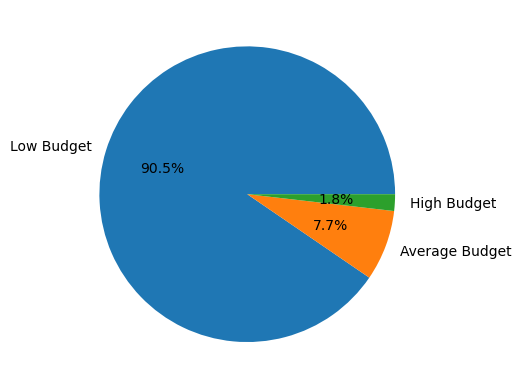

In [75]:
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.pie(y,autopct='%1.1f%%',labels=['Low Budget','Average Budget','High Budget'])
plt.show()

# Bar plot Budget Categories by Decades

<Figure size 1000x200 with 0 Axes>

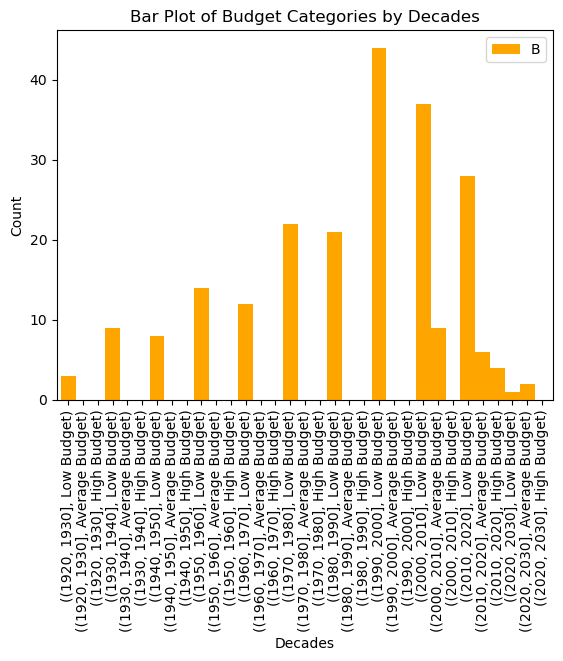

In [143]:
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()

pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])

# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches

# Create a stacked bar plot
pivot_df.plot(kind='bar',width=1,color='orange', stacked=True)

# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Bar Plot of Budget Categories by Decades')
plt.legend( "Budget")
# Show the plot
plt.show()


In [38]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    plt.show()

The r-value is:  0.010447790724258036


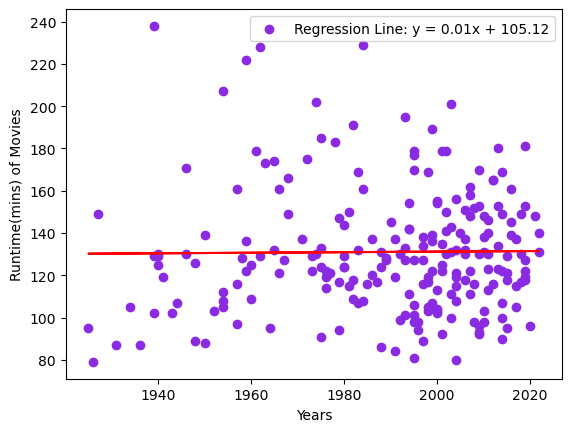

In [39]:
# Create a scatter plot for regression analysis

xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  -0.08419223144975718


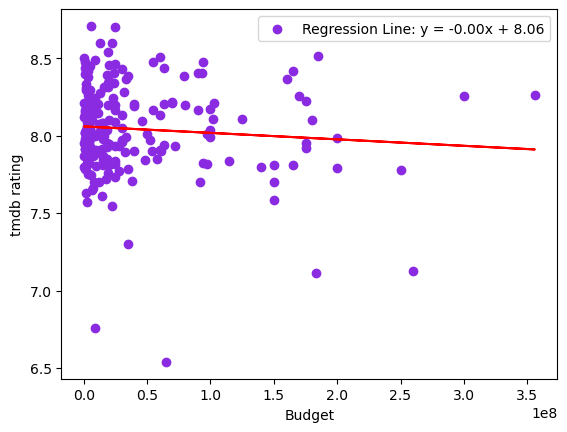

In [40]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='Budget'
y_label='tmdb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  -0.05240744897982001


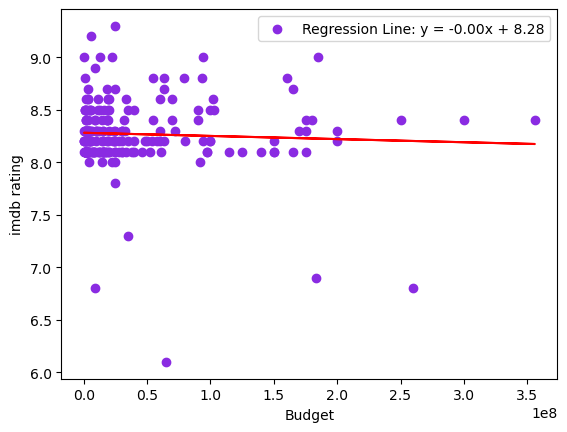

In [41]:
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget'
y_label='imdb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.02861426922820671


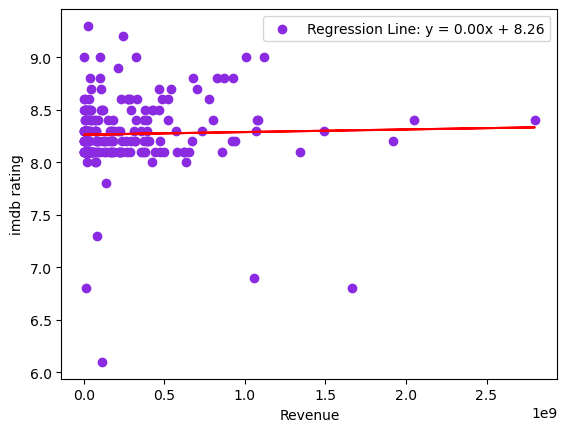

In [42]:
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue'
y_label='imdb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.1421159076299597


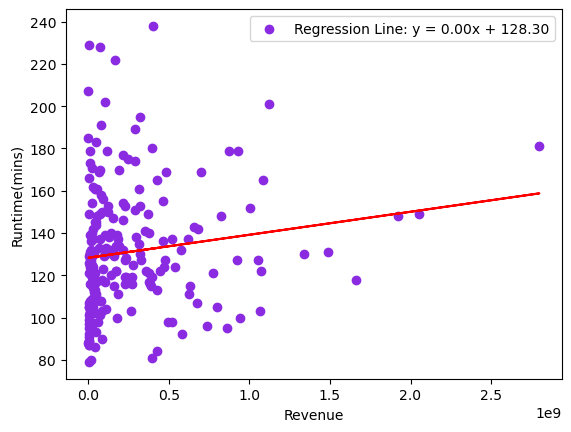

In [43]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue'
y_label='Runtime(mins)'

lin_regress(xval, yval, x_label, y_label)

In [44]:
# movie_list.loc["genres"].value_counts()

In [45]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

FileNotFoundError: [Errno 2] No such file or directory: 'the_oscar_award.csv'

In [ ]:
# Check how many Oscar nominations each film has
oscar_list["film"].value_counts()

In [ ]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head(2)

In [ ]:
# Check how many Golden Globe nominations each film has
gglobe_list["film"].value_counts()

In [ ]:
# # This will split a cell with multiple values back into a list
# newvar = movie_list.loc[9, "production_countries"].split(", ")
# newvar[2]

In [ ]:
# # Testing the Pandas "explode" function
# checkexplode = movie_list["genres"].explode('drama')
# checkexplode

In [ ]:
# Create a "contains value" function in Python to call on to pull specific genre or production country information
def contains_value(val, search_val):
    return search_val in val.split(', ')

In [ ]:
# crime_df = movie_list[movie_list['genres'].apply(lambda x: contains_value(x, 'Crime'))]
# drama_df = movie_list[movie_list['genres'].apply(lambda x: contains_value(x, 'Drama'))]


# # merge1_df = pd.merge(crime_df, drama_df, on=["Title", "Year", "id", "budget", "revenue", "popularity"])
# # merge1_df
# # merge1_df.groupby["Year"]
# # merge1_df

In [ ]:
# # Creating empty lists to split multiple-value columns' values into
# genre_list = []
# prod_country_list = []

# for index, row in movie_list.iterrows():
#     genre_list.append(movie_list.loc[index, "genres"].split(", "))
#     prod_country_list.append(movie_list.loc[index, "production_countries"])

# genre_df = pd.DataFrame(genre_list)
# prod_country_df = pd.DataFrame(prod_country_list)
# genre_df